Assessing the regional variation in sea ice concentration throughout each month using daily NASA Team sea ice concentrations Figure. 7

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import scipy
import datetime
import cartopy.feature as cfeature
import calendar
import geopandas as gpd
from shapely.prepared import prep
from shapely.geometry import Point

In [2]:
def polygon_masking(grid_x,grid_y,shapefile):
    x_flt = grid_x.flatten()
    y_flt = grid_y.flatten()

    # Prepare shapefiles for processing
    geom = shapefile.geometry.union_all()
    p_geom = prep(geom)

    # Use flattened x and y coordinates to find points within the polygon
    mask_flt = np.array([p_geom.contains(Point(x, y)) for x, y in zip(x_flt, y_flt)])
    # Reshape the mask back to the original array shape
    mask = mask_flt.reshape(grid_x.shape)

    return(mask)

Centre grid shape =  (58, 131)
Edges grid shape =  (59, 132)


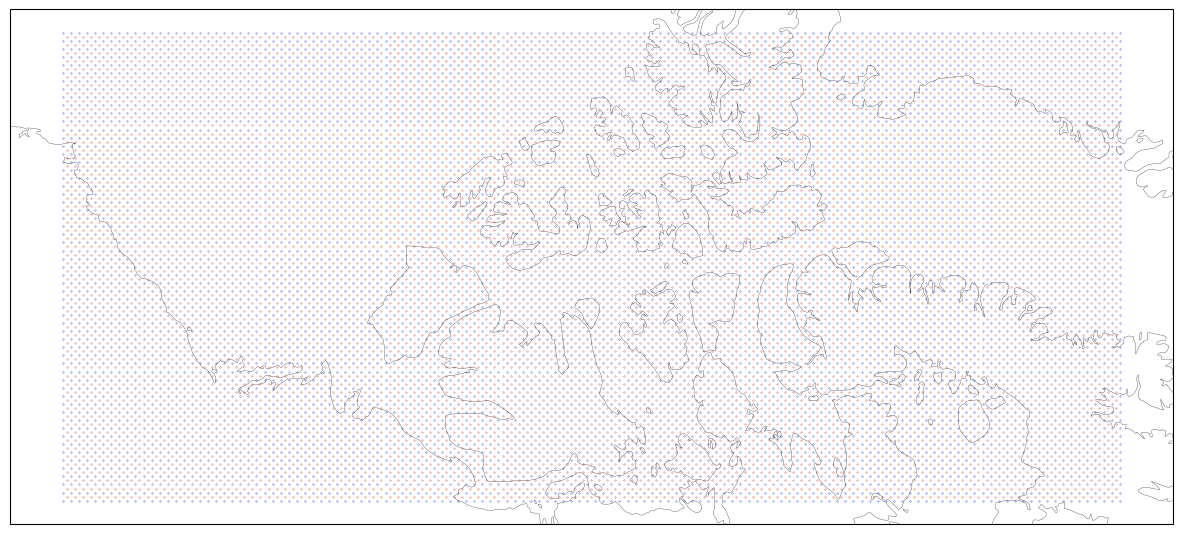

In [3]:
# Define the custom Lambert Azimuthal Equal Area projection
map_projection = ccrs.LambertAzimuthalEqualArea(central_longitude=-105,central_latitude=74)

# Coordinates to transform (lon, lat) in the Plate Carree projection
geo_extent = [-140, -70, 64, 79]

def transform_coords(lon, lat, projection):
    x, y = projection.transform_point(lon, lat, ccrs.PlateCarree())
    return x, y

# Get corners of 'bounding box' from geo_extent
corners = [
    (geo_extent[0], geo_extent[2]),  # SW corner
    (geo_extent[1], geo_extent[2]),  # SE corner
    (geo_extent[0], geo_extent[3]),  # NW corner
    (geo_extent[1], geo_extent[3])   # NE corner
]

# Transform coordinates to the desired map area
proj_corners = [transform_coords(lon, lat, map_projection) for lon, lat in corners]
x_coords, y_coords = zip(*proj_corners)

x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

grid_spacing = 25000 # 25 km

x_grid_centre = np.arange(x_min-grid_spacing/2,x_max + grid_spacing/2, grid_spacing)
y_grid_centre = np.arange(y_min-grid_spacing/2,y_max + grid_spacing/2, grid_spacing)
new_x_centre, new_y_centre = np.meshgrid(x_grid_centre, y_grid_centre) # For PMV & CIS data (regridded)

x_grid_edge = np.arange(x_min-grid_spacing,x_max + grid_spacing, grid_spacing)
y_grid_edge = np.arange(y_min-grid_spacing,y_max + grid_spacing, grid_spacing)
new_x_edge, new_y_edge= np.meshgrid(x_grid_edge, y_grid_edge) # For CS2 data (gridded)

print('Centre grid shape = ',np.shape(new_x_centre)) 
print('Edges grid shape = ',np.shape(new_x_edge)) # edges should be one greater than centres

# Set up the figure
fig = plt.figure(figsize=(15, 20))
ax = plt.axes(projection=map_projection)
ax.coastlines(linewidth=0.2)
ax.scatter(new_x_centre,new_y_centre,0.05, color='red')
ax.scatter(new_x_edge,new_y_edge,0.05, color='blue')
plt.show()


In [4]:
months = ['10','11','12','01','02','03','04','05']
mean_stacked_stds = {}
for month in months:
    std_arrays = []
    for year in range(2010,2024):
        std_array = np.load('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC/PMV_Daily_Std_All/'+str(year)+str(month)+'_PMV_Std_Array.npy')

        std_arrays.append(std_array)

    stacked_stds = np.stack(std_arrays,axis=0)
    mean_stacked_std = np.nanmean(stacked_stds,axis=0)
    mean_stacked_stds[month] = mean_stacked_std

/var/folders/q1/prwbhm6j6x1gcchb7r0p2kyh0000gn/T/ipykernel_2124/2548049973.py:11: RuntimeWarning: Mean of empty slice
  mean_stacked_std = np.nanmean(stacked_stds,axis=0)


In [5]:
# Define regions
# We split the CAA into the Beaufort Sea, the Central CAA, & Baffin Bay

# Import shapefiles of the desired regions
bs_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BeaufortSea_Shapefile.shp')
caa_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/Central_CAA_Shapefile.shp')
bb_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BaffinBay_Shapefile.shp')

regions = {'BS':bs_shp,'CAA':caa_shp,'BB':bb_shp}
months = ['10','11','12','01','02','03','04','05']

std_regional_means = []

for region, shapefile in regions.items():
    mask = polygon_masking(new_x_centre,new_y_centre,shapefile)
    for month in months:
        
        # # Ice Std # #
        std_masked_data = np.where(mask,mean_stacked_stds[month],np.nan)

        # Save the means to an array
        std_mean = np.nanmean(std_masked_data)
        std_regional_means.append({'Region':region,'Month':month,'Mean':std_mean})

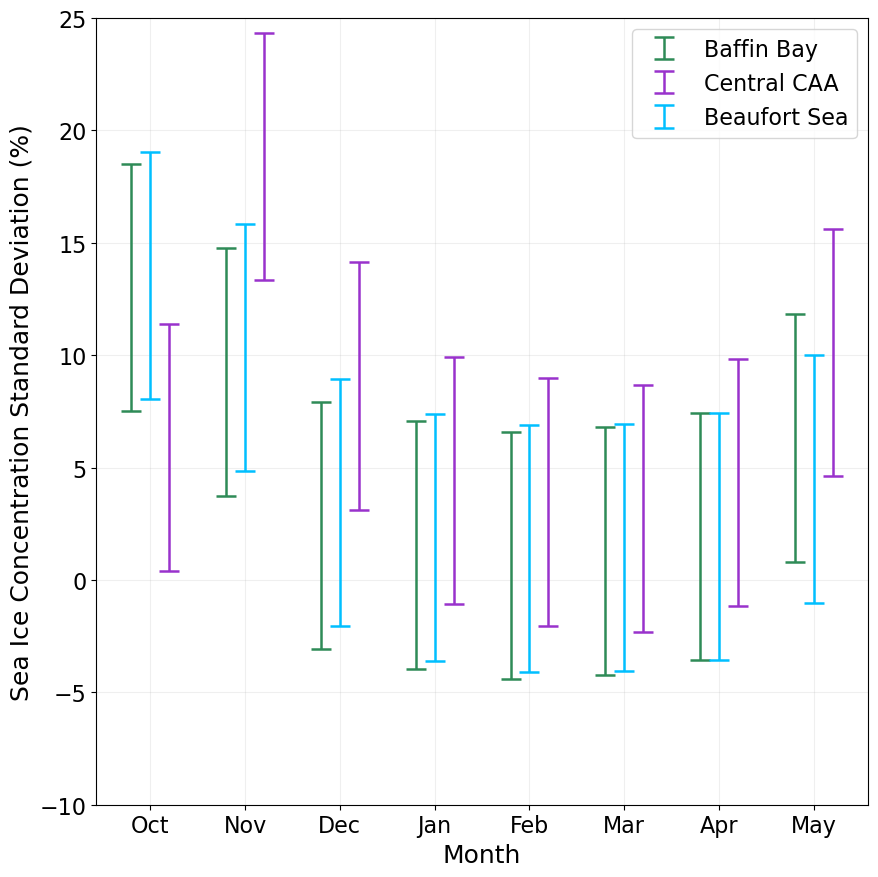

In [6]:
months = [entry['Month'] for entry in std_regional_means]
means = [entry['Mean'] for entry in std_regional_means]
regions = [entry['Region'] for entry in std_regional_means]

region_colors = {'BS': 'seagreen', 'CAA': 'deepskyblue', 'BB': 'darkorchid'}

fig_a, ax_a = plt.subplots(figsize=[9,9])
plt.rcParams.update({'font.size': 14})

x_x = ['10','11','12','01','02','03','04','05']

x_offset = {'BS': -0.2, 'CAA': 0.0, 'BB': 0.2} 

legend_handles, legend_labels = [],[]

for region in set(regions):
    region_months = [months[i] for i in range(len(months)) if regions[i] == region]
    region_means = [means[i] for i in range(len(means)) if regions[i] == region]
    x_shifted = [x_x.index(month) + x_offset[region] for month in region_months]

    plot = ax_a.errorbar(x=x_shifted,y=region_means,yerr=5.5,color=region_colors[region],capsize = 7,capthick = 1.8,
                       linewidth = 1.8,linestyle = 'none',label=region)


ax_a.set_xlabel('Month', fontsize = 18)
ax_a.set_ylim(-10, 25)
ax_a.xaxis.grid(True,'major',alpha=0.2)
ax_a.yaxis.grid(True,'major',alpha=0.2)
ax_a.set_xticks([0,1,2,3,4,5,6,7])
ax_a.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May'])
ax_a.set_ylabel('Sea Ice Concentration Standard Deviation (%)', fontsize = 18)

plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)

ax_a.legend(['Baffin Bay', 'Central CAA','Beaufort Sea'],fontsize=16, loc='upper right')

plt.tight_layout()
plt.show()

fig_a.savefig('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC_Plots/ReSubmission_Plots/Fig07_RegionalStd.png',dpi=300,bbox_inches="tight")